Trabajaremos con el dataset de aparcamientos, utilizando como fuente el fichero del
mes de diciembre de 2019. Realizar la ingesta y transformación de datos de forma que
podamos obtener las siguientes características en el dataset:

o Parking

o Day

o Month

o Year

o Timeslot (0..23)

o Dayweek (L/M/X/J/V/S/D)

o Schoolday (S/N)

o Holidayday(S/N)

o Temperature

o Humidity

o NumCheckin

o NumCheckout

Este proyecto tiene como objetivo entrenar un modelo de inteligencia artificial capaz de predecir entradas o salidas deseadas. Para lograrlo, se deben llevar a cabo tareas como el análisis de datos, selección de características, escalamiento y entrenamiento, incluyendo pruebas de hiperparametrización, CrossValidation y selección del mejor modelo en términos de rendimiento. Además, es necesario implementar el modelo en una pequeña aplicación web con un servicio API para permitir a los usuarios finales validar la validez del modelo. Se debe mejorar la usabilidad de la aplicación ofreciendo opciones como combos, check boxs, radio buttons y calendarios. 

In [119]:
# Importaciones necesarias
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import holidays
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import mean_absolute_error


Descargamos el exel o csv y lo pasamos a dataFrame

In [3]:
df19 = pd.read_excel("/content/APARCAMIENTOS-DICIEMBRE-2019.xlsx")
df22 = pd.read_excel("/content/APARCAMIENTOS-DICIEMBRE-2022.xlsx")

In [4]:
#Leo el csv que contiene tanto la temperatura como la humedad de año de 2019 y 2022, lo guardo en una variable. Este csv lo he sacado utilizando Web scrapper.
weather = pd.read_csv("/content/weather.csv")

In [5]:
weather22 = pd.read_csv("/content/weather22.csv")

####Tratamiento de los Datos 2019

Eliminamos del todo el dataframe los aparcamientos de San Bernardo ya que hay una gran franja en la cual no hay datos.

In [6]:
filtro = df19['APARCAMIENTO'] != 'SAN BERNARDO'
df19 = df19[filtro]
# el método reset_index, lo que hace es eliminar el index anterior y crear uno nuevo,
# esto te sirve en caso de que hayas hecho una modificación al dataframe.
df19.reset_index(drop=True, inplace=True)
df19

,GarageNo,APARCAMIENTO,EventTime,EventDesc
0,8855,ELDER,2019-12-01 00:37:16,Salida
1,8855,ELDER,2019-12-01 01:17:08,Salida
2,8855,ELDER,2019-12-01 03:06:42,Salida
3,8855,ELDER,2019-12-01 08:09:06,Entrada
4,8855,ELDER,2019-12-01 10:43:24,Salida
...,...,...,...,...
268146,8601,VEGUETA,2019-12-31 23:10:18,Entrada
268147,8601,VEGUETA,2019-12-31 23:28:00,Salida
268148,8601,VEGUETA,2019-12-31 23:28:24,Entrada
268149,8601,VEGUETA,2019-12-31 23:29:52,Salida


Pasamos los dos campos eventos de categóricos a numéricos 

In [7]:
df19['EventDesc'] = df19['EventDesc'].replace({'Salida': 0, 'Entrada': 1})
df19['EventDesc'].astype(int)

0         0
1         0
2         0
3         1
4         0
         ..
268146    1
268147    0
268148    1
268149    0
268150    0
Name: EventDesc, Length: 268151, dtype: int64

In [8]:
df19['EventTime'] = pd.to_datetime(df19['EventTime'])

In [9]:
df19['year'] = df19['EventTime'].dt.year
df19['month'] = df19['EventTime'].dt.month
df19['day'] = df19['EventTime'].dt.day
df19['hour'] = df19['EventTime'].dt.hour

Los dias estaran distribuidos de la siguiente manera:

| 1 | 2 | 3 | 4 | 5 | 6 | 7 |
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|Lunes|Martes|Miercoles|Jueves|Viernes|Sábado|Domingo|

In [10]:
#dw_mapping={
#    1: 'M', 
#    2: 'T', 
#    3: 'W', 
#    4: 'T', 
#    5: 'F',
#    6: 'St', 
#    7: 'Sn'
#}
#df19['day_of_week'] = df19['EventTime'].dt.weekday.map(dw_mapping)

df19['day_of_week'] = (df19['EventTime'].dt.weekday + 1)

Después de haber guardado lo que nos interesaba del la columna de *EventTime*, ya la podríamos eliminar, junto a la otra columna de *GarageNo*.

In [11]:
df19.drop(['GarageNo'], axis = 1, inplace = True)
df19.drop(['EventTime'], axis = 1, inplace = True)

Lo que vamos a hacer es cambiar el nombre del campo APARCAMIENTO a parking y el de EventDesc a event.

In [12]:
df19.rename(columns={'APARCAMIENTO':'parking', 'EventDesc': 'event'},
               inplace=True)

Comprobamos las columnas que se encuentran dentro del dataframe y comprobamos de que tipo es cada tipo.

In [13]:
df19.columns

Index(['parking', 'event', 'year', 'month', 'day', 'hour', 'day_of_week'], dtype='object')

In [14]:
df19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268151 entries, 0 to 268150
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   parking      268151 non-null  object
 1   event        268151 non-null  int64 
 2   year         268151 non-null  int64 
 3   month        268151 non-null  int64 
 4   day          268151 non-null  int64 
 5   hour         268151 non-null  int64 
 6   day_of_week  268151 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 14.3+ MB


Creamos una columna la cual nos proporciona la informacion de si es o no festivo aquí en las islas canarias, para ello utilizaremos una librería llamada holidays que nos proporciona los dias festivos de cualquier año y lugar.

In [15]:
holi = []
for holiday in holidays.Spain(years=2019, prov = 'CN').items():
  holi.append(holiday[0])
#  holiday[0] muestra unicamente la fecha   

In [16]:
#Crearemos un array con los valores de 1 y 0, para si o no
is_holiday = []
for i in range(len(df19)):
  date = datetime(df19['year'][i], df19['month'][i], df19['day'][i])
  if date.date() in holi or df19['day_of_week'][i] == 7 :
    is_holiday.append(1)
  else:
    is_holiday.append(0)

df19['is_holiday'] = is_holiday

Separamos del event las entradas (CheckIn) y las salidas (CheckOut). Para que así se pueda utilizar el metodo groupby que nos proporciona pandas.

In [17]:
df19['CheckIn'] = (df19['event'] == 1).astype(int)
df19['CheckOut'] = (df19['event'] == 0).astype(int)

Lo que hacemos ahora es hacer un groupby para así contar las entradas y las salidas totales por horas, dias , año y parking. 

In [18]:
df_Actual = df19.groupby(['parking', 'year', 'month', 'day', 'hour', 'day_of_week', 'is_holiday'], as_index=False)[['CheckIn', 'CheckOut']].sum()

El siguiente array lo tuve que hacer de manera manual ya que no encontré nada que nos facilitara dicho trabajo. En el podemos encontrar las fechas que son festivas unicamente en el mes de diciembre.

In [19]:
no_school_days = [datetime(2019,12,6).date(), datetime(2019,12,9).date(), datetime(2019,12,23).date(), datetime(2019,12,24).date(), datetime(2019,12,25).date(), datetime(2019,12,26).date(), datetime(2019,12,27).date(), datetime(2019,12,30).date(), datetime(2019,12,31).date()]

In [20]:
school_days = []
for i in range(len(df_Actual)):
  date = datetime(df_Actual['year'][i], df_Actual['month'][i], df_Actual['day'][i])
  if date.date() in no_school_days or df_Actual['day_of_week'][i] == 7 or df_Actual['day_of_week'][i] == 6 :
    school_days.append(0)
  else:
    school_days.append(1)

df_Actual['school_day'] = school_days

De vez en cuando muestro el dataframe para comprobar que todo está correcto

In [21]:
df_Actual 

,parking,year,month,day,hour,day_of_week,is_holiday,CheckIn,CheckOut,school_day
0,ELDER,2019,12,1,0,7,1,16,23,0
1,ELDER,2019,12,1,1,7,1,8,25,0
2,ELDER,2019,12,1,2,7,1,1,22,0
3,ELDER,2019,12,1,3,7,1,1,23,0
4,ELDER,2019,12,1,4,7,1,0,10,0
...,...,...,...,...,...,...,...,...,...,...
4045,VEGUETA,2019,12,31,19,2,0,14,44,0
4046,VEGUETA,2019,12,31,20,2,0,11,20,0
4047,VEGUETA,2019,12,31,21,2,0,10,8,0
4048,VEGUETA,2019,12,31,22,2,0,1,3,0


####Tratamiento del csv Weather

Elimino los campos que no son importantes 

In [22]:
weather.drop(['web-scraper-order'], axis = 1, inplace = True)
weather.drop(['web-scraper-start-url'], axis = 1, inplace = True)
weather.drop(['pagination'], axis = 1, inplace = True)

In [23]:
weather = weather[weather['Hora'].notna()]

Con el siguiente código vemos si hay algún valor nulo.

In [24]:
weather.reset_index(drop=True, inplace=True)
weather.isnull().sum()

Día            0
Hora           0
Temperatura    0
Humedad        0
dtype: int64

Utilizando la variable Día que contiene el dataframe weather para añadir en el mismo varias colunas que nos son útiles como son: *day*, *month* y *year* las cuales usaremos más adelante.

In [25]:
# pongo el 12 en el mes porque resulta más sencillo pero si no la solución
# para poder agregar otros meses, es hacer un diccionario y que los meses los pase a numeros.
day = []
month = []
year = []
from datetime import datetime
for i in range(len(weather)):
  lista_palabras = weather['Día'][i].split()
  day.append(pd.to_datetime(lista_palabras[1], format='%d').day)
  month.append(pd.to_datetime(12, format='%m').month)
  year.append(pd.to_datetime(lista_palabras[3], format='%Y').year)

weather['day'] = day
weather['month'] = month
weather['year'] = year

El siguiente código lo que hace es que divide la columna *Hora* en dos columnas nuevas *hour* y *min*. Que se intuye de que son hora y minuto.

In [26]:
hour = []
min = []

for i in range(len(weather)):
  lista_palabras = weather['Hora'][i].split(':')
  hour.append(pd.to_datetime(lista_palabras[0], format='%H').hour)
  min.append(pd.to_datetime(lista_palabras[1], format='%M').minute)

weather['hour'] = hour
weather['min'] = min

In [27]:
weather.drop(['Día'], axis = 1, inplace = True)
weather.drop(['Hora'], axis = 1, inplace = True)

Lo que vamos a hacer aquí es de todos los minutos que hay, elegir las 30 debido a que es la mediana de cada franja horaria.

In [28]:
weather.drop(weather[(weather['min'] != 30)].index, inplace=True)
weather.drop(['min'], axis = 1, inplace = True)

Aquí quitamos los simbolos a Temperatura y a Humedad.

In [29]:
weather['Temperatura'] = weather['Temperatura'].replace('°', '', regex=True)
weather['Humedad'] = weather['Humedad'].replace('%', '', regex=True)
weather.reset_index(drop=True, inplace=True)

In [30]:
weather

,Temperatura,Humedad,day,month,year,hour
0,20,83,1,12,2019,0
1,20,83,1,12,2019,1
2,20,78,1,12,2019,2
3,19,83,1,12,2019,3
4,19,78,1,12,2019,4
...,...,...,...,...,...,...
737,18,56,31,12,2019,19
738,17,45,31,12,2019,20
739,17,27,31,12,2019,21
740,18,26,31,12,2019,22


Añado cada temperatura y humedad a cada franja horaria de cada dia del mes

In [31]:
#weather.loc[0,'hour']
for i in range(len(weather)):
    index = df_Actual.loc[(df_Actual['hour'] == weather.loc[i, 'hour']) & (df_Actual['day'] == weather.loc[i, 'day'])].index.tolist()
    df_Actual.loc[index,'Temperatura'] = weather.loc[i,'Temperatura']
    df_Actual.loc[index,'Humedad'] = weather.loc[i,'Humedad']

Hago el siguiente código para rellenar los datos nulos del dataframe con la media de los datos de su alrededor.

In [32]:
df_Actual = df_Actual.fillna(df_Actual.rolling(10, min_periods=1).mean())

<ipython-input-32-593ec4e3ce59>:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['parking'], dtype='object')
  df_Actual = df_Actual.fillna(df_Actual.rolling(10, min_periods=1).mean())


In [33]:
df_Actual.isnull().sum()

parking        0
year           0
month          0
day            0
hour           0
day_of_week    0
is_holiday     0
CheckIn        0
CheckOut       0
school_day     0
Temperatura    0
Humedad        0
dtype: int64

In [34]:
#Pasamos los dos eventos categóricos a numéricos ELDER, VEGUETA, SANAPU, RINCON, METROPOL, MATA, ELDER
df_Actual['parking'] = df_Actual['parking'].replace({'ELDER': 0, 'VEGUETA': 1, 'SANAPU': 2, 'RINCON': 3, 'METROPOL': 4, 'MATA': 5})

Y para finalizar hacemos un reinicio de los índices.

In [35]:
df_Actual.reset_index(drop=True, inplace=True)

In [36]:
df_Actual['Temperatura'] = df_Actual['Temperatura'].astype(int)
df_Actual['Humedad'] = df_Actual['Humedad'].astype(int)
df_Actual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4050 entries, 0 to 4049
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   parking      4050 non-null   int64
 1   year         4050 non-null   int64
 2   month        4050 non-null   int64
 3   day          4050 non-null   int64
 4   hour         4050 non-null   int64
 5   day_of_week  4050 non-null   int64
 6   is_holiday   4050 non-null   int64
 7   CheckIn      4050 non-null   int64
 8   CheckOut     4050 non-null   int64
 9   school_day   4050 non-null   int64
 10  Temperatura  4050 non-null   int64
 11  Humedad      4050 non-null   int64
dtypes: int64(12)
memory usage: 379.8 KB


####Tratamiento de los Datos 2022

Eliminamos del todo el dataframe los aparcamientos de San Bernardo ya que hay una gran franja en la cual no hay datos.

In [37]:
filtro = df22['APARCAMIENTO'] != 'SAN BERNARDO'
df22 = df22[filtro]
# el método reset_index, lo que hace es eliminar el index anterior y crear uno nuevo,
# esto te sirve en caso de que hayas hecho una modificación al dataframe.
df22.reset_index(drop=True, inplace=True)
df22

,APARCAMIENTO,EventTime,EventDesc
0,VEGUETA,2022-12-01 00:11:30.000,SALIDA
1,VEGUETA,2022-12-01 00:13:46.000,SALIDA
2,VEGUETA,2022-12-01 00:24:56.000,ENTRADA
3,VEGUETA,2022-12-01 00:31:32.000,SALIDA
4,VEGUETA,2022-12-01 00:33:20.000,SALIDA
...,...,...,...
261231,SANAPÚ,2022-12-29 08:41:27.410,SALIDA
261232,SANAPÚ,2022-12-30 07:27:31.970,ENTRADA
261233,SANAPÚ,2022-12-30 07:28:39.640,SALIDA
261234,SANAPÚ,2022-12-30 07:58:08.300,ENTRADA


Pasamos los dos eventos categóricos a numéricos 


In [38]:
df22['EventDesc'] = df22['EventDesc'].replace({'SALIDA': 0, 'ENTRADA': 1})
df22['EventDesc'].astype(int)

0         0
1         0
2         1
3         0
4         0
         ..
261231    0
261232    1
261233    0
261234    1
261235    0
Name: EventDesc, Length: 261236, dtype: int64

In [39]:
df22['EventTime'] = pd.to_datetime(df22['EventTime'])

In [40]:
df22['year'] = df22['EventTime'].dt.year
df22['month'] = df22['EventTime'].dt.month
df22['day'] = df22['EventTime'].dt.day
df22['hour'] = df22['EventTime'].dt.hour

Los dias estaran distribuidos de la siguiente manera:

| 1 | 2 | 3 | 4 | 5 | 6 | 7 |
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|Lunes|Martes|Miercoles|Jueves|Viernes|Sábado|Domingo|

In [41]:
#dw_mapping={
#    1: 'M', 
#    2: 'T', 
#    3: 'W', 
#    4: 'T', 
#    5: 'F',
#    6: 'St', 
#    7: 'Sn'
#}
#df22['day_of_week'] = df22['EventTime'].dt.weekday.map(dw_mapping)

df22['day_of_week'] = (df22['EventTime'].dt.weekday + 1)

In [42]:
df22.drop(['EventTime'], axis = 1, inplace = True)

Lo que vamos a hacer es cambiar el nombre del campo APARCAMIENTO a parking y el de EventDesc a event.

In [43]:
df22.rename(columns={'APARCAMIENTO':'parking', 'EventDesc': 'event'},
               inplace=True)

Comprobamos las columnas que se encuentran dentro del dataframe

In [44]:
df22.columns

Index(['parking', 'event', 'year', 'month', 'day', 'hour', 'day_of_week'], dtype='object')

In [45]:
df22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261236 entries, 0 to 261235
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   parking      261236 non-null  object
 1   event        261236 non-null  int64 
 2   year         261236 non-null  int64 
 3   month        261236 non-null  int64 
 4   day          261236 non-null  int64 
 5   hour         261236 non-null  int64 
 6   day_of_week  261236 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 14.0+ MB


Crear columna la cual nos proporciona la informacion de si es o no festivo aquí en las islas canarias, para ello utilizaremos una librería llamada holidays que nos proporciona los dias festivos de cualquier año y lugar.

In [46]:
holi = []
for holiday in holidays.Spain(years=2022, prov = 'CN').items():
  holi.append(holiday[0])
#  holiday[0] muestra unicamente la fecha   

In [47]:
#Crearemos un array con los valores de 1 y 0, para si o no
is_holiday = []
for i in range(len(df22)):
  date = datetime(df22['year'][i], df22['month'][i], df22['day'][i])
  if date.date() in holi or df22['day_of_week'][i] == 7 :
    is_holiday.append(1)
  else:
    is_holiday.append(0)

df22['is_holiday'] = is_holiday

Separamos del event las entradas (CheckIn) y las salidas (CheckOut). Para que así se pueda utilizar el metodo groupby que nos proporciona pandas.

In [48]:
df22['CheckIn'] = (df22['event'] == 1).astype(int)
df22['CheckOut'] = (df22['event'] == 0).astype(int)

lo que hacemos ahora es hacer un groupby para así contar las entradas y las salidas totales por horas, dias , año y parking. 

In [49]:
df_Actual_22 = df22.groupby(['parking', 'year', 'month', 'day', 'hour', 'day_of_week', 'is_holiday'], as_index=False)[['CheckIn', 'CheckOut']].sum()

El siguiente array lo tuve que hacer de manera manual ya que no encontré nada que nos facilitara dicho trabajo. En el podemos encontrar las fechas que son festivas unicamente en el mes de diciembre.

In [50]:
no_school_days = [datetime(2019,12,6).date(), datetime(2019,12,7).date(), datetime(2019,12,8).date(), datetime(2019,12,23).date(), datetime(2019,12,26).date(), datetime(2019,12,27).date(), datetime(2019,12,28).date(), datetime(2019,12,29).date(), datetime(2019,12,30).date()]

In [51]:
school_days = []
for i in range(len(df_Actual_22)):
  date = datetime(df_Actual_22['year'][i], df_Actual_22['month'][i], df_Actual_22['day'][i])
  if date.date() in no_school_days or df_Actual_22['day_of_week'][i] == 7 or df_Actual_22['day_of_week'][i] == 6 :
    school_days.append(0)
  else:
    school_days.append(1)

df_Actual_22['school_day'] = school_days

De vez en cuando muestro el dataframe para comprobar que todo está correcto

In [52]:
df_Actual_22.info

<bound method DataFrame.info of       parking  year  month  day  hour  day_of_week  is_holiday  CheckIn  \
0       ELDER  2022     12    1     0            4           0        0   
1       ELDER  2022     12    1     1            4           0        0   
2       ELDER  2022     12    1     4            4           0        0   
3       ELDER  2022     12    1     5            4           0        1   
4       ELDER  2022     12    1     6            4           0        8   
...       ...   ...    ...  ...   ...          ...         ...      ...   
4013  VEGUETA  2022     12   31    19            6           0       15   
4014  VEGUETA  2022     12   31    20            6           0       10   
4015  VEGUETA  2022     12   31    21            6           0        8   
4016  VEGUETA  2022     12   31    22            6           0        4   
4017  VEGUETA  2022     12   31    23            6           0        4   

      CheckOut  school_day  
0            9           1  
1        

####Tratamiento del csv Weather 22

Elimino los campos que no son importantes 

In [53]:
weather22.drop(['web-scraper-order'], axis = 1, inplace = True)
weather22.drop(['web-scraper-start-url'], axis = 1, inplace = True)
weather22.drop(['pagination'], axis = 1, inplace = True)

In [54]:
weather22 = weather22[weather22['Hora'].notna()]

Con el siguiente código vemos si hay algún valor nulo.

In [55]:
weather22.reset_index(drop=True, inplace=True)
weather22.isnull().sum()

Día            0
Hora           0
Temperatura    0
Humedad        0
dtype: int64

Utilizando la variable Día que contiene el dataframe weather para añadir en el mismo varias colunas que nos son útiles como son: day, month y year las cuales usaremos más adelante.

In [56]:
# pongo el 12 en el mes porque resulta más sencillo pero si no la solución
# para poder agregar otros meses, es hacer un diccionario y que los meses los pase a numeros.
day = []
month = []
year = []
from datetime import datetime
for i in range(len(weather22)):
  lista_palabras = weather22['Día'][i].split()
  day.append(pd.to_datetime(lista_palabras[1], format='%d').day)
  month.append(pd.to_datetime(12, format='%m').month)
  year.append(pd.to_datetime(lista_palabras[3], format='%Y').year)

weather22['day'] = day
weather22['month'] = month
weather22['year'] = year

El siguiente código lo que hace es que divide la columna Hora en dos columnas nuevas hour y min. Que se intuye de que son hora y minuto.

In [57]:
hour = []
min = []

for i in range(len(weather22)):
  lista_palabras = weather22['Hora'][i].split(':')
  hour.append(pd.to_datetime(lista_palabras[0], format='%H').hour)
  min.append(pd.to_datetime(lista_palabras[1], format='%M').minute)

weather22['hour'] = hour
weather22['min'] = min

In [58]:
weather22.drop(['Día'], axis = 1, inplace = True)
weather22.drop(['Hora'], axis = 1, inplace = True)

Lo que vamos a hacer aquí es de todos los minutos que hay, elegir las 30 debido a que es la mediana de cada franja horaria.

In [59]:
weather22.drop(weather22[(weather22['min'] != 30)].index, inplace=True)
weather22.drop(['min'], axis = 1, inplace = True)

Aquí quitamos los simbolos a Temperatura y a Humedad.

In [60]:
weather22['Temperatura'] = weather22['Temperatura'].replace('°', '', regex=True)
weather22['Humedad'] = weather22['Humedad'].replace('%', '', regex=True)
weather22.reset_index(drop=True, inplace=True)

In [61]:
weather22

,Temperatura,Humedad,day,month,year,hour
0,19,64,1,12,2022,0
1,19,60,1,12,2022,1
2,19,64,1,12,2022,2
3,18,68,1,12,2022,3
4,19,60,1,12,2022,4
...,...,...,...,...,...,...
739,19,78,31,12,2022,19
740,18,83,31,12,2022,20
741,18,83,31,12,2022,21
742,18,83,31,12,2022,22


Añado cada temperatura y humedad a cada franja horaria de cada dia del mes

In [62]:
#weather22.loc[0,'hour']
for i in range(len(weather22)):
    index = df_Actual_22.loc[(df_Actual_22['hour'] == weather22.loc[i, 'hour']) & (df_Actual_22['day'] == weather22.loc[i, 'day'])].index.tolist()
    df_Actual_22.loc[index,'Temperatura'] = weather22.loc[i,'Temperatura']
    df_Actual_22.loc[index,'Humedad'] = weather22.loc[i,'Humedad']

Hago el siguiente código para rellenar los datos nulos del dataframe con la media de los datos de su alrededor.

In [63]:
df_Actual_22 = df_Actual_22.fillna(df_Actual_22.rolling(10, min_periods=1).mean())

<ipython-input-63-eda551a5ecc8>:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['parking'], dtype='object')
  df_Actual_22 = df_Actual_22.fillna(df_Actual_22.rolling(10, min_periods=1).mean())


In [64]:
df_Actual_22.isnull().sum()

parking        0
year           0
month          0
day            0
hour           0
day_of_week    0
is_holiday     0
CheckIn        0
CheckOut       0
school_day     0
Temperatura    0
Humedad        0
dtype: int64

In [65]:
#Pasamos los dos eventos categóricos a numéricos ELDER, VEGUETA, SANAPU, RINCON, METROPOL, MATA, ELDER
df_Actual_22['parking'] = df_Actual_22['parking'].replace({'ELDER': 0, 'VEGUETA': 1, 'SANAPÚ': 2, 'RINCÓN': 3, 'METROPOL': 4, 'MATA': 5})

In [66]:
df_Actual_22.reset_index(drop=True, inplace=True)

In [67]:
df_Actual_22['Temperatura'] = df_Actual_22['Temperatura'].astype(int)
df_Actual_22['Humedad'] = df_Actual_22['Humedad'].astype(int)
df_Actual_22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   parking      4018 non-null   int64
 1   year         4018 non-null   int64
 2   month        4018 non-null   int64
 3   day          4018 non-null   int64
 4   hour         4018 non-null   int64
 5   day_of_week  4018 non-null   int64
 6   is_holiday   4018 non-null   int64
 7   CheckIn      4018 non-null   int64
 8   CheckOut     4018 non-null   int64
 9   school_day   4018 non-null   int64
 10  Temperatura  4018 non-null   int64
 11  Humedad      4018 non-null   int64
dtypes: int64(12)
memory usage: 376.8 KB


####Matríz de Correlación

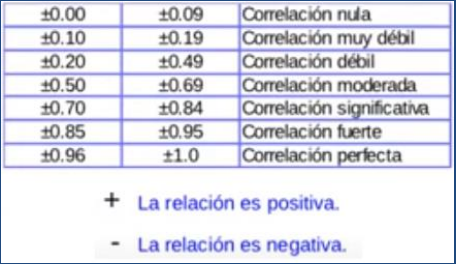

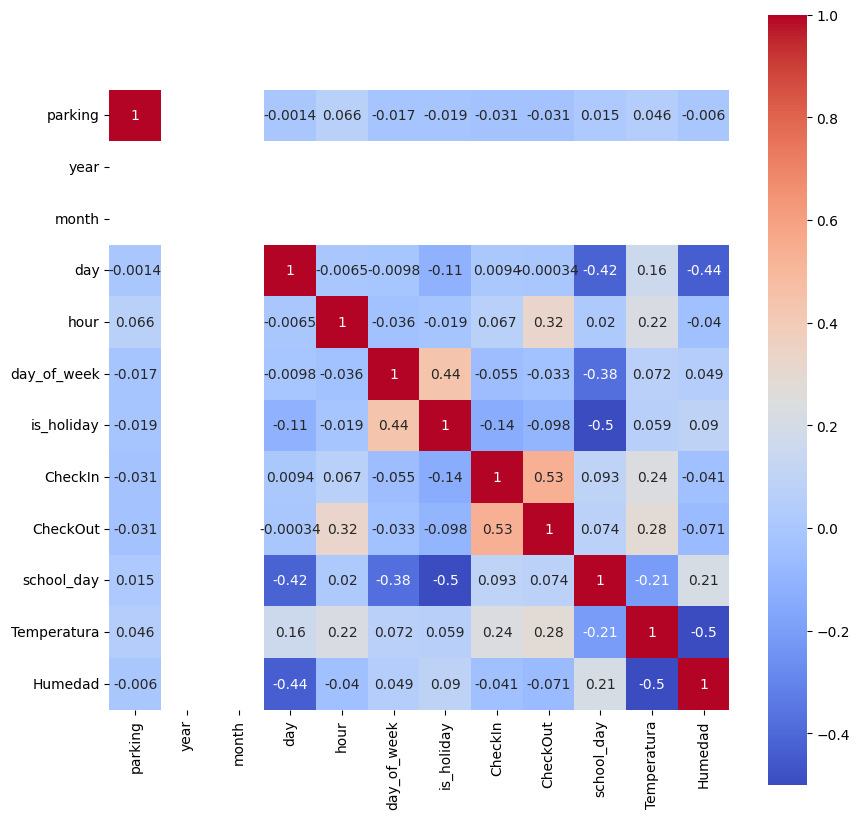

In [68]:
# Crear el heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_Actual.corr(), cmap='coolwarm', annot=True, square=True)
# Encontré un parámetro  que te lo realiza todo como una huella calorifica, es decir, 
# los que tienen más correlación te los pone en rojo y los que menos te los pone en azul
plt.show()

Tras haber observado la matriz de Correlación, podemos concluir que la mayoría de los campos tienen una correlación negativa y se comprende entre nula y debil, los campos que comparten una mayor correlación son *CheckIn* con *CheckOut*, es algo comprensible porque si un coche entra tiene que salir si o si. Se preguntará porque los campos *year* y *month* no tienen un número que los defina y eso se debe a que ambos solo tienen un valos que es 2019 y 12 respectivamente por ello no se les puede sacar la correlación.

####RandomForestRegressor _ CheckIn

en el siguiente ejemplo no utilizo el escalado, debido a que el mae aumenta

In [69]:
train = df_Actual.loc[(df_Actual['day'].isin(range(1,21)))]
test  = df_Actual.loc[(df_Actual['day'].isin(range(21,32)))]
#train = df_Actual_X
#test = df_Actual_y

In [70]:
# reseteamos el index con el fin de evitar problemas en la validación cruzada
train.reset_index(drop = True, inplace = True)

In [71]:
train_x = train.drop(['CheckIn','CheckOut'],axis = 1)
train_y = train['CheckIn']

test_x = test.drop(['CheckIn','CheckOut'],axis = 1)
test_y = test['CheckIn']

scaler = MaxAbsScaler()
train_x[train_x.columns] = scaler.fit_transform(train_x)
test_x[test_x.columns] = scaler.fit_transform(test_x)


Selección de los Hiperparámetros del modelo

In [72]:
params_dist = {
              "n_estimators": [16, 32, 64, 128, 256, 512, 1024], # Number of trees in random forest
              "max_features": ['sqrt', 'log2', None], # Number of features (características) when looking for the best split (división)
              "max_depth": [32,16,8], # Maximum number of levels in tree
              "min_samples_split": [2, 4, 6, 8], #  Minimum number of samples required to split a node
              "min_samples_leaf": [8, 12, 16, 22], # Minimum number of samples required at each leaf(hoja) node
              'random_state': range(1,30),
               'criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
              # Al utilizar timeSeriesSplit en GridSearchCV tuve que quitar el parámetro True para que no diese error
              # El utilizar TimeSeriesSplit en GridSearchCV implica un ajuste en los hiperparámetros para las pruebas con series temporales
              # ya que pueden provocar error
              # Importante: la validación cruzada en series de tiempo, como TimeSeriesSplit, es una forma adecuada de evaluar el rendimiento 
              # de los modelos de aprendizaje automático en datos temporales. Sin embargo, es importante tener en cuenta que, 
              # en algunos casos, puede producir puntajes de validación cruzada más bajos que otros métodos de validación cruzada debido 
              # a la rigurosidad de la división de los datos en conjuntos de entrenamiento y validación.
              #
              #"bootstrap": [False] # Method of selecting for training each tree, If False, the whole dataset is used to build each tree.
                            # Use False when the dataset use Temporal id
              "bootstrap": [True, False] # Method of selecting for training each tree, If False, the whole dataset is used to build each tree.
            }

In [73]:
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
rand = RandomForestRegressor()

# MUY INTERESANTE: Probar a realizar el entrenamienmto utilizando timeSeriesSplit y comentar las diferencias en lsoresultados obtenidos
tscv = TimeSeriesSplit()
#rnd_regres = RandomizedSearchCV(estimator = rand, param_distributions = param_dist, n_iter = 100, cv = tscv, random_state=0, n_jobs = -1)
rnd_regres = RandomizedSearchCV(rand, params_dist, n_iter = 100, cv = tscv, error_score='raise')

# Fit the random search model
rnd_regres.fit(X = train_x, y = train_y)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   error_score='raise', estimator=RandomForestRegressor(),
                   n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['squared_error',
                                                      'absolute_error',
                                                      'friedman_mse',
                                                      'poisson'],
                                        'max_depth': [32, 16, 8],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [8, 12, 16, 22],
                                        'min_samples_split': [2, 4, 6, 8],
                                        'n_estimators': [16, 32, 64, 128, 256,
                                                         512, 1024],
                                        'random_state': range(1, 30)})

In [74]:
def report(results, n_top=3): # Función para mostrar resultados
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [75]:
report(rnd_regres.cv_results_, n_top = 5)

Model with rank: 1
Mean validation score: 0.255 (std: 0.129)
Parameters: {'random_state': 27, 'n_estimators': 64, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 8, 'criterion': 'friedman_mse', 'bootstrap': True}

Model with rank: 2
Mean validation score: 0.246 (std: 0.214)
Parameters: {'random_state': 29, 'n_estimators': 512, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 8, 'criterion': 'poisson', 'bootstrap': False}

Model with rank: 3
Mean validation score: 0.244 (std: 0.116)
Parameters: {'random_state': 14, 'n_estimators': 1024, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 32, 'criterion': 'squared_error', 'bootstrap': True}

Model with rank: 4
Mean validation score: 0.236 (std: 0.108)
Parameters: {'random_state': 12, 'n_estimators': 32, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 8, 'criterion': 'squared_error', 'bootstrap': True}

Model 

In [76]:
rnd_regres.best_params_

{'random_state': 27,
 'n_estimators': 64,
 'min_samples_split': 6,
 'min_samples_leaf': 8,
 'max_features': None,
 'max_depth': 8,
 'criterion': 'friedman_mse',
 'bootstrap': True}

In [77]:
# Ahora hacemos la predicción con el dataframe del 2022
prediccon = df_Actual_22.drop(['CheckIn','CheckOut'],axis = 1)

#Se escala
prediccon[prediccon.columns] = scaler.fit_transform(prediccon)

# choose the best
best_random = rnd_regres.best_estimator_
# fit and predict
best_random.fit( X = train_x, y = train_y)
y_pred_in = best_random.predict(X = prediccon)

# EVALUATE 
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(df_Actual_22['CheckIn'], y_pred_in)
print ('MAE', mae)

MAE 12.873997345937024


/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


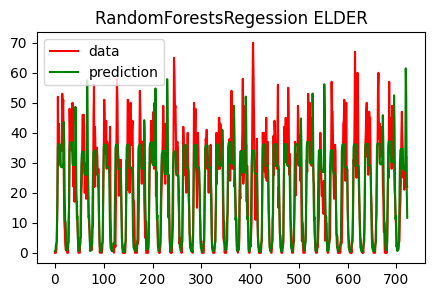

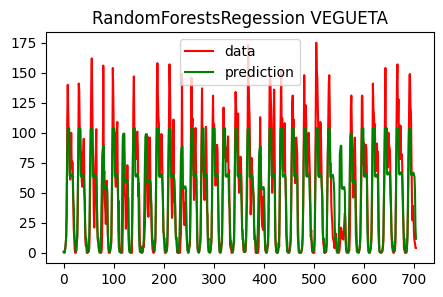

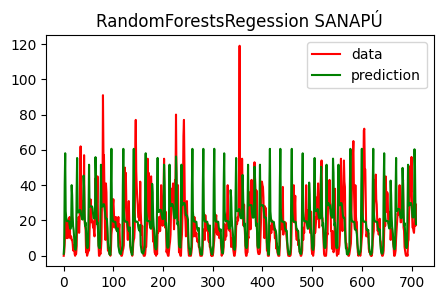

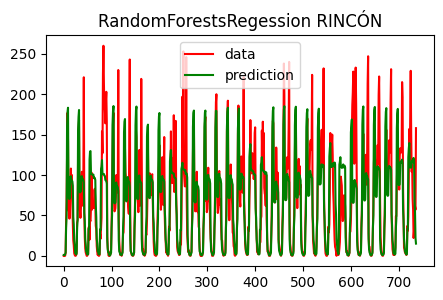

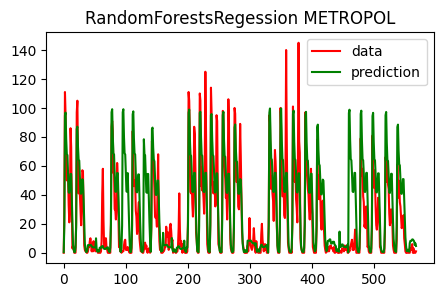

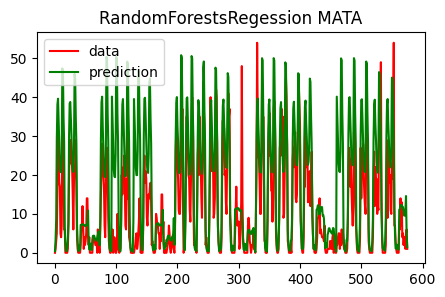

In [121]:
#mostraré por separado cada una de los parking
nombres = ['ELDER', 'VEGUETA', 'SANAPÚ', 'RINCÓN', 'METROPOL', 'MATA']
for i in range(len(nombres)):
  #lo que hago aqui es crear una lista donde guardo los indices de los parking especificos para luego mostrarlos
  lista = df_Actual_22.index[df_Actual_22['parking'] == i].tolist()
  nuevo_df = df_Actual_22.iloc[lista, :]
  presentar = y_pred_in[lista]

  # x axis for plotting
  plt.figure(figsize=(5, 3))
  xx = np.stack(i for i in range(nuevo_df['CheckIn'].shape[0]))
  plt.plot(xx, nuevo_df['CheckIn'], c='r', label='data')
  plt.plot(xx, presentar, c='g', label='prediction')
  plt.axis('tight')
  plt.legend()
  plt.title(f"RandomForestsRegession {nombres[i]}")
  plt.show()

Text(0, 0.5, 'Predicted CheckIn')

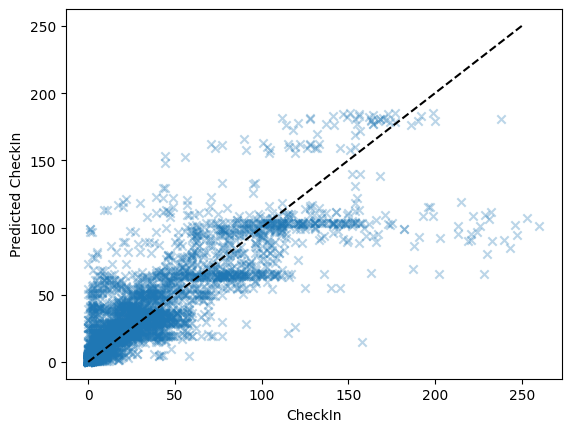

In [79]:
plt.scatter(df_Actual_22['CheckIn'], y_pred_in , alpha = 0.3, marker = 'x')
plt.plot([0, 250], [0, 250], "--k")
plt.axis("tight")
plt.xlabel("CheckIn")
plt.ylabel("Predicted CheckIn")

# Interpretación de la gráfica:
# En la diagonal están los valores de test, y los puntos dispersos son las predicción. De esta forma podemos ver lo cerca/lejos que están los resultados
# predichos de los de entrenamiento
# Cuanto más cerca están las X de la recta mejor será la predicción.

#####Exportar a un fichero los parámetros del modelo entrenado.

In [80]:
!pip install joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [81]:
# Para exportar el modelo a un fichero
import sklearn.externals 
import joblib
joblib.dump(best_random,'CheckIn.pkl')

['CheckIn.pkl']

####RandomForestRegressor _ CheckOut

en el siguiente ejemplo no utilizo el escalado, debido a que el mae aumenta

In [82]:
train = df_Actual.loc[(df_Actual['day'].isin(range(1,21)))]
test  = df_Actual.loc[(df_Actual['day'].isin(range(21,32)))]
#train = df_Actual_X
#test = df_Actual_y

In [83]:
# reseteamos el index con el fin de evitar problemas en la validación cruzada
train.reset_index(drop = True, inplace = True)

In [84]:
train_x = train.drop(['CheckIn','CheckOut'],axis = 1)
train_y = train['CheckOut']

test_x = test.drop(['CheckIn','CheckOut'],axis = 1)
test_y = test['CheckOut']

scaler = MaxAbsScaler()
train_x[train_x.columns] = scaler.fit_transform(train_x)
test_x[test_x.columns] = scaler.fit_transform(test_x)


In [85]:
params_dist = {
              "n_estimators": [16, 32, 64, 128, 256, 512, 1024], # Number of trees in random forest
              "max_features": ['sqrt', 'log2', None], # Number of features (características) when looking for the best split (división)
              "max_depth": [32,16,8], # Maximum number of levels in tree
              "min_samples_split": [2, 4, 6, 8], #  Minimum number of samples required to split a node
              "min_samples_leaf": [8, 12, 16, 22], # Minimum number of samples required at each leaf(hoja) node
              'random_state': range(1,30),
               'criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
              # Al utilizar timeSeriesSplit en GridSearchCV tuve que quitar el parámetro True para que no diese error
              # El utilizar TimeSeriesSplit en GridSearchCV implica un ajuste en los hiperparámetros para las pruebas con series temporales
              # ya que pueden provocar error
              # Importante: la validación cruzada en series de tiempo, como TimeSeriesSplit, es una forma adecuada de evaluar el rendimiento 
              # de los modelos de aprendizaje automático en datos temporales. Sin embargo, es importante tener en cuenta que, 
              # en algunos casos, puede producir puntajes de validación cruzada más bajos que otros métodos de validación cruzada debido 
              # a la rigurosidad de la división de los datos en conjuntos de entrenamiento y validación.
              #
              #"bootstrap": [False] # Method of selecting for training each tree, If False, the whole dataset is used to build each tree.
                            # Use False when the dataset use Temporal id
              "bootstrap": [True] # Method of selecting for training each tree, If False, the whole dataset is used to build each tree.
            }

In [86]:
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
rand = RandomForestRegressor()

# MUY INTERESANTE: Probar a realizar el entrenamienmto utilizando timeSeriesSplit y comentar las diferencias en lsoresultados obtenidos
tscv = TimeSeriesSplit()
#rnd_regres = RandomizedSearchCV(estimator = rand, param_distributions = param_dist, n_iter = 100,  random_state=0, n_jobs = -1)
rnd_regres = RandomizedSearchCV(rand, params_dist, n_iter = 100, cv = tscv, error_score='raise')

# Fit the random search model
rnd_regres.fit(X = train_x, y = train_y)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   error_score='raise', estimator=RandomForestRegressor(),
                   n_iter=100,
                   param_distributions={'bootstrap': [True],
                                        'criterion': ['squared_error',
                                                      'absolute_error',
                                                      'friedman_mse',
                                                      'poisson'],
                                        'max_depth': [32, 16, 8],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [8, 12, 16, 22],
                                        'min_samples_split': [2, 4, 6, 8],
                                        'n_estimators': [16, 32, 64, 128, 256,
                                                         512, 1024],
                                        'random_state': range(1, 30)})

In [87]:
def report(results, n_top=3): # Función para mostrar resultados
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [88]:
report(rnd_regres.cv_results_, n_top = 5)

Model with rank: 1
Mean validation score: 0.184 (std: 0.153)
Parameters: {'random_state': 13, 'n_estimators': 64, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 32, 'criterion': 'poisson', 'bootstrap': True}

Model with rank: 2
Mean validation score: 0.171 (std: 0.156)
Parameters: {'random_state': 22, 'n_estimators': 64, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 32, 'criterion': 'absolute_error', 'bootstrap': True}

Model with rank: 3
Mean validation score: 0.170 (std: 0.168)
Parameters: {'random_state': 14, 'n_estimators': 32, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 32, 'criterion': 'squared_error', 'bootstrap': True}

Model with rank: 4
Mean validation score: 0.169 (std: 0.160)
Parameters: {'random_state': 5, 'n_estimators': 1024, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 32, 'criterion': 'friedman_mse', 'bootstrap': True}

Model

In [89]:
rnd_regres.best_params_

{'random_state': 13,
 'n_estimators': 64,
 'min_samples_split': 8,
 'min_samples_leaf': 8,
 'max_features': None,
 'max_depth': 32,
 'criterion': 'poisson',
 'bootstrap': True}

In [90]:
# Ahora hacemos la predicción con el dataframe del 2022
prediccon = df_Actual_22.drop(['CheckIn','CheckOut'],axis = 1)

#Lo escalamos
prediccon[prediccon.columns] = scaler.fit_transform(prediccon)

# choose the best
best_random = rnd_regres.best_estimator_
# fit and predict
best_random.fit( X = train_x, y = train_y)
y_pred_out = best_random.predict(X = prediccon)

# EVALUATE 
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(df_Actual_22['CheckOut'], y_pred_out)
print ('MAE', mae)

MAE 10.857444866119149


/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


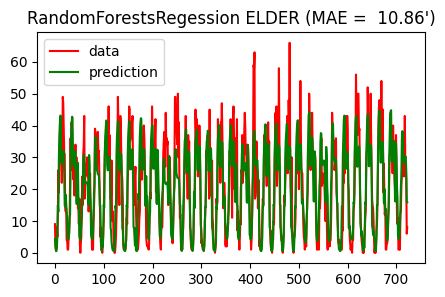

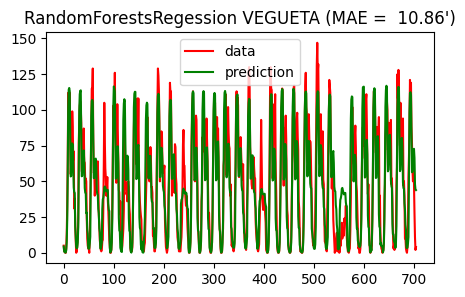

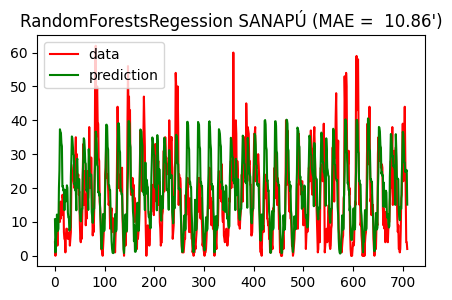

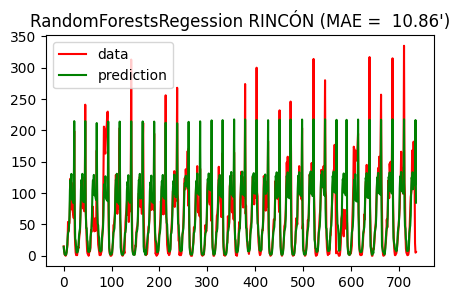

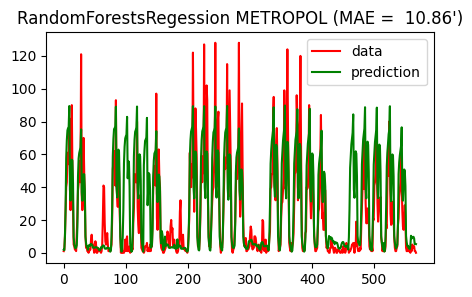

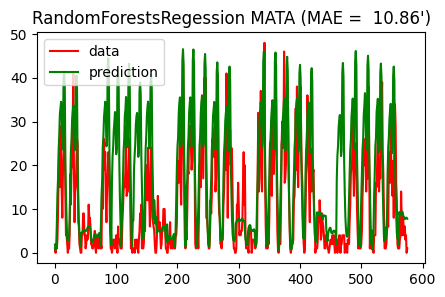

In [120]:
#mostraré por separado cada una de los parking
nombres = ['ELDER', 'VEGUETA', 'SANAPÚ', 'RINCÓN', 'METROPOL', 'MATA']
for i in range(len(nombres)):
  #lo que hago aqui es crear una lista donde guardo los indices de los parking especificos para luego mostrarlos
  lista = df_Actual_22.index[df_Actual_22['parking'] == i].tolist()
  nuevo_df = df_Actual_22.iloc[lista, :]
  presentar = y_pred_out[lista]

  # x axis for plotting
  plt.figure(figsize=(5, 3))
  xx = np.stack(i for i in range(nuevo_df['CheckOut'].shape[0]))
  plt.plot(xx, nuevo_df['CheckOut'], c='r', label='data')
  plt.plot(xx, presentar, c='g', label='prediction')
  plt.axis('tight')
  plt.legend()
  plt.title(f"RandomForestsRegession {nombres[i]}")
  plt.show()

Text(0, 0.5, 'Predicted CheckOut')

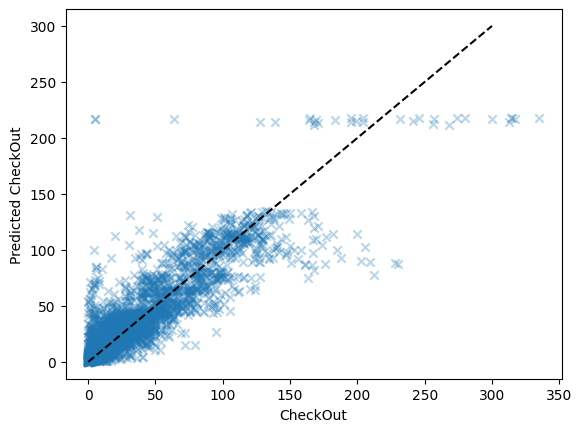

In [93]:
plt.scatter(df_Actual_22['CheckOut'], y_pred_out , alpha = 0.3, marker = 'x')
plt.plot([0, 300], [0, 300], "--k")
plt.axis("tight")
plt.xlabel("CheckOut")
plt.ylabel("Predicted CheckOut")

# Interpretación de la gráfica:
# En la diagonal están los valores de test, y los puntos dispersos son las predicción. De esta forma podemos ver lo cerca/lejos que están los resultados
# predichos de los de entrenamiento
# Cuanto más cerca están las X de la recta mejor será la predicción.

#####Exportar a un fichero los parámetros del modelo entrenado.

In [94]:
!pip install joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [95]:
# Para exportar el modelo a un fichero
import sklearn.externals 
import joblib
joblib.dump(best_random,'CheckOut.pkl')

['CheckOut.pkl']

### Descargar excel con las diversas comparaciones de datos.

In [96]:
resultados = pd.DataFrame()
resultados['CheckIn'] = df_Actual_22['CheckIn']

In [97]:
from google.colab import files

resultados['Predicción CheckIn'] = y_pred_in
resultados['CheckOut'] = df_Actual['CheckOut']
resultados['Predicción CheckOut'] = y_pred_out

resultados.to_excel('resultados_Segulpa.xlsx', index = False)

files.download('resultados_Segulpa.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [98]:
resultados

,CheckIn,Predicción CheckIn,CheckOut,Predicción CheckOut
0,0,0.487582,23,4.317733
1,0,0.428423,25,2.501790
2,0,2.760984,22,0.562202
3,1,3.129240,23,0.526405
4,8,3.775901,10,1.810489
...,...,...,...,...
4013,15,65.150813,98,72.769369
4014,10,63.299112,104,66.417240
4015,8,52.321454,123,48.018889
4016,4,20.988171,96,44.263965


In [99]:
scaler.fit_transform(df_Actual[['parking', 'day','month','year', 'hour', 'is_holiday', 'day_of_week', 'school_day', 'Temperatura', 'Humedad']])
joblib.dump(scaler,'scaler.pkl')

['scaler.pkl']

In [100]:
files.download('scaler.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>